# Import required libraries

In [1]:
# !pip install kaggle
# !pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from IPython.display import Image
import os
import shutil
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


2025-03-15 08:14:01.987318: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 08:14:01.987384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 08:14:01.987431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 08:14:01.996681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import dataset from Kaggle via command line

In [3]:

# os.environ["KAGGLE_USERNAME"] = "XXXXX"
# os.environ["KAGGLE_KEY"] = "XXXXX"

In [4]:
# !kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images

In [5]:
# import zipfile

# def unzip_file(zip_file_path, extract_to_path):
#     # Ensure the extraction directory exists
#     if not os.path.exists(extract_to_path):
#         os.makedirs(extract_to_path)
    
#     # Open the zip file in read mode and extract all contents
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_path)
#         print(f"Extracted all files to {extract_to_path}")

In [6]:
main_dir = './CVDATASET'
train_dataset_dir = main_dir + "/train"
test_dataset_dir = main_dir + "/test"

In [7]:
# zip_file_path = "./cifake-real-and-ai-generated-synthetic-images.zip"
# extract_to_path = main_dir
# unzip_file(zip_file_path, extract_to_path)

# Check GPU usage

In [8]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
tf.debugging.set_log_device_placement(True)

# Create a small tensor to test GPU usage
a = tf.constant([[1.0, 2.0, 3.0]])
b = tf.constant([[4.0, 5.0, 6.0]])

c = tf.matmul(a, tf.transpose(b))
print(c)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


2025-03-15 08:14:04.925301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:09.0, compute capability: 8.0
2025-03-15 08:14:04.957394: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:04.957422: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:04.957429: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:06.111034: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:06.111086: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:06.11

# Actual model building

In [10]:
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
print(val_ds.class_names)

Found 100000 files belonging to 2 classes.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/t

2025-03-15 08:14:40.448405: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:40.448491: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.448499: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.453015: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:40.453050: I tensorflow/core/common_runtime/placer.cc:125] TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:40.453057: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:40.468890: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0


2025-03-15 08:14:40.886951: I tensorflow/core/common_runtime/placer.cc:125] condition: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.887013: I tensorflow/core/common_runtime/placer.cc:125] t: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.887019: I tensorflow/core/common_runtime/placer.cc:125] e: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.887026: I tensorflow/core/common_runtime/placer.cc:125] SelectV2: (SelectV2): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:40.887030: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
perm: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
Transpose: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
y_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
a: (

2025-03-15 08:14:41.610591: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.610686: I tensorflow/core/common_runtime/placer.cc:125] DummySeedGenerator: (DummySeedGenerator): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.613072: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.613104: I tensorflow/core/common_runtime/placer.cc:125] buffer__size: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.613111: I tensorflow/core/common_runtime/placer.cc:125] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.613116: I tensorflow/core/common_runtime/placer.cc:125] seed2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:41.613121: I tensorflow/core/common_runtime/placer.cc:125] seed__generator: (_Arg): /job:localhost/replica:0/task:

Found 20000 files belonging to 2 classes.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/

2025-03-15 08:14:48.617910: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:48.617955: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:48.617967: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:48.617972: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


In [11]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [12]:
# Load Pre-trained ResNet Model
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
ResNet_base_model.trainable = False  # Freeze the base model

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

2025-03-15 08:14:48.657623: I tensorflow/core/common_runtime/placer.cc:125] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:48.657655: I tensorflow/core/common_runtime/placer.cc:125] StatelessRandomGetKeyCounter: (StatelessRandomGetKeyCounter): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.657662: I tensorflow/core/common_runtime/placer.cc:125] key_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.657666: I tensorflow/core/common_runtime/placer.cc:125] counter_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.660618: I tensorflow/core/common_runtime/placer.cc:125] shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:14:48.660645: I tensorflow/core/common_runtime/placer.cc:125] key: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.660651: I tensorflow/core/common_runtime/placer.cc:125] counter: (_Arg): /job:localhost/replic

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

2025-03-15 08:14:48.902928: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.902961: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.904277: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.904305: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:48.904314: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

2025-03-15 08:14:49.138307: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.138360: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.139978: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.140010: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.140018: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.143066: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.143097: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in d

2025-03-15 08:14:49.725778: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.725829: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.727427: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.727457: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.727468: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.730511: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:49.730543: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

2025-03-15 08:14:50.514897: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.514948: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.516552: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.516584: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.516593: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.519517: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.519548: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

2025-03-15 08:14:50.929596: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.929649: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.931284: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.931311: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:50.931319: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
e_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:

2025-03-15 08:14:51.285233: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.285283: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.285296: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.287742: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.287768: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.287777: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.295184: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

2025-03-15 08:14:51.513880: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.513935: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.513947: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.524548: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.524586: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.524595: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.534101: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
calhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:

2025-03-15 08:14:51.728856: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.728883: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.728892: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.743018: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.743052: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.743061: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-03-15 08:14:51.745222: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device

In [18]:
# Extract features using a pre-trained ResNet model
feature_extractor = tf.keras.Model(
    inputs=ResNet_base_model.input, 
    outputs=ResNet_base_model.layers[-2].output
)

start_time = time.time()

# Convert dataset to numpy arrays
X_train = np.concatenate([feature_extractor(x) for x, _ in train_ds])
X_test = np.concatenate([feature_extractor(x) for x, _ in val_ds])
# Ensure labels are in integer format
y_train = np.concatenate([y.numpy() for _, y in train_ds])
y_test = np.concatenate([y.numpy() for _, y in val_ds])

# If labels are one-hot encoded, convert to class indices
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0


2025-03-15 08:43:05.814109: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814248: I tensorflow/core/common_runtime/placer.cc:125] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814262: I tensorflow/core/common_runtime/placer.cc:125] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814275: I tensorflow/core/common_runtime/placer.cc:125] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814282: I tensorflow/core/common_runtime/placer.cc:125] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814290: I tensorflow/core/common_runtime/placer.cc:125] resize/Squeeze: (Squeeze): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:43:05.814297: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identit

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pad in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:l

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:lo

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devi

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fuse

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in dev

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:lo

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FusedBatchNormV3 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:lo

2025-03-15 08:44:51.762837: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762903: I tensorflow/core/common_runtime/placer.cc:125] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762910: I tensorflow/core/common_runtime/placer.cc:125] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762916: I tensorflow/core/common_runtime/placer.cc:125] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762920: I tensorflow/core/common_runtime/placer.cc:125] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762925: I tensorflow/core/common_runtime/placer.cc:125] resize/Squeeze: (Squeeze): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:44:51.762929: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identit

Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/devic

2025-03-15 08:45:12.824431: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824493: I tensorflow/core/common_runtime/placer.cc:125] ReadFile: (ReadFile): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824500: I tensorflow/core/common_runtime/placer.cc:125] decode_image/DecodeImage: (DecodeImage): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824509: I tensorflow/core/common_runtime/placer.cc:125] resize/ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824514: I tensorflow/core/common_runtime/placer.cc:125] resize/ResizeBilinear: (ResizeBilinear): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824518: I tensorflow/core/common_runtime/placer.cc:125] resize/Squeeze: (Squeeze): /job:localhost/replica:0/task:0/device:CPU:0
2025-03-15 08:45:12.824523: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identit

Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/devic

In [19]:
X_train.shape

(100000, 1, 1, 2048)

In [20]:
y_train.shape

(100000,)

In [22]:
# Reshape to 2D: (num_samples, num_features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(100000, 2048)

In [23]:
# Train Random Forest classifier and record training time
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)
train_time = time.time() - start_time

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)
y_train_proba = rf_classifier.predict_proba(X_train)
y_test_proba = rf_classifier.predict_proba(X_test)

# Metrics Calculation
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "auc": roc_auc_score
}

results = {}
for metric_name, metric_func in metrics.items():
    if metric_name == "auc":
        results[f"train_{metric_name}"] = metric_func(y_train, y_train_proba[:, 1])
        results[f"test_{metric_name}"] = metric_func(y_test, y_test_proba[:, 1])
    elif metric_name in ["precision", "recall", "f1_score"]:
        results[f"train_{metric_name}"] = metric_func(y_train, y_train_pred, average='weighted')
        results[f"test_{metric_name}"] = metric_func(y_test, y_test_pred, average='weighted')
    else:  # For accuracy_score
        results[f"train_{metric_name}"] = metric_func(y_train, y_train_pred)
        results[f"test_{metric_name}"] = metric_func(y_test, y_test_pred)

# Display results
print(f"Training time: {train_time:.2f} seconds")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Training time: 2994.74 seconds
train_accuracy: 0.9954
test_accuracy: 0.5006
train_precision: 0.9954
test_precision: 0.5006
train_recall: 0.9954
test_recall: 0.5006
train_f1_score: 0.9954
test_f1_score: 0.5004
train_auc: 1.0000
test_auc: 0.5020


In [26]:
# import joblib

# # Save the model
# joblib.dump(rf_classifier, "random_forest_model.pkl")

# # Load the model later
# rf_classifier_loaded = joblib.load("random_forest_model.pkl")


y_test_proba shape: (20000, 2)


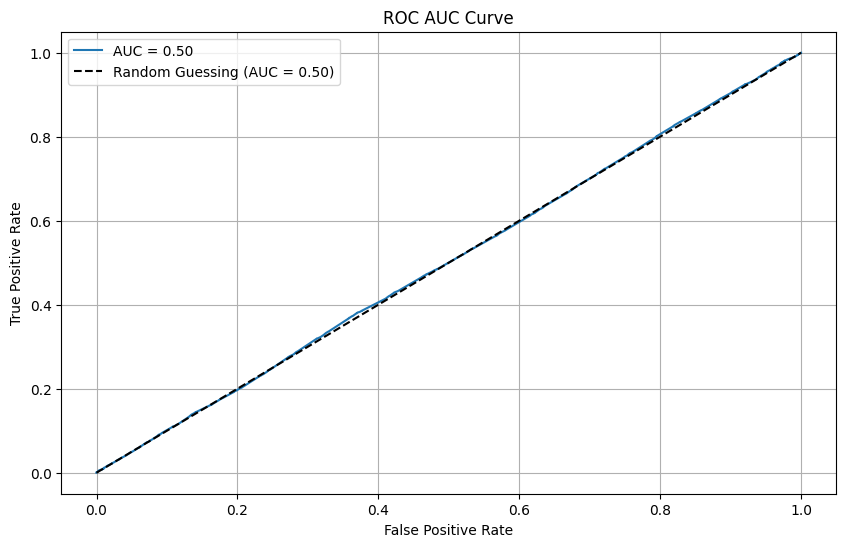

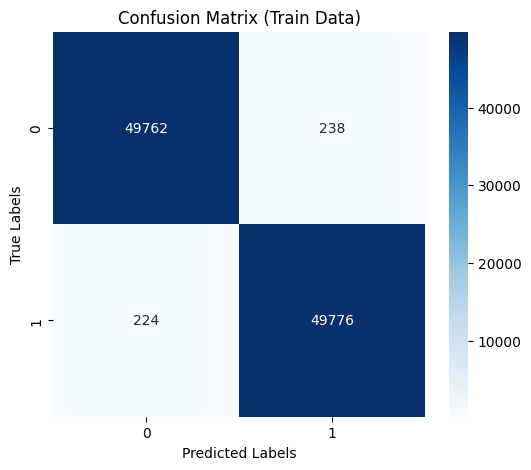

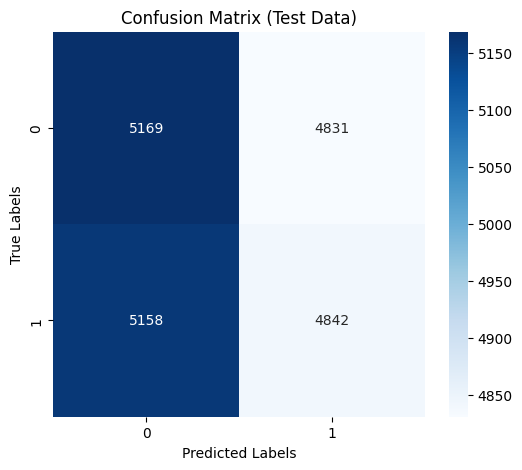

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# Get class labels
class_labels = np.unique(y_train)  # Unique class labels
n_classes = len(class_labels)

# Check the shape of y_test_proba
print("y_test_proba shape:", y_test_proba.shape)

# --- Plot ROC AUC Curves ---
plt.figure(figsize=(10, 6))

# Handle Binary Classification Case
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])  # Use the second column for positive class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

# Handle Multi-Class Classification
else:
    y_train_bin = label_binarize(y_train, classes=class_labels)
    y_test_bin = label_binarize(y_test, classes=class_labels)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {roc_auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend()
plt.grid()
plt.show()

# --- Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred, dataset_type="Test"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix ({dataset_type} Data)")
    plt.show()

# Plot Confusion Matrix for Training Data
plot_confusion_matrix(y_train, y_train_pred, dataset_type="Train")

# Plot Confusion Matrix for Test Data
plot_confusion_matrix(y_test, y_test_pred, dataset_type="Test")
